In [1]:
import requests
import json

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 22})

import numpy as np
import scipy as sp

import quandl as q
from hmmlearn import hmm

In [2]:
urlbase = 'https://www.alphavantage.co/query?' #function=TIME_SERIES_INTRADAY&symbol=MSFT&interval=5min&apikey=demo
apikey = 'XSO6JQY0HMLGU4HS'

params = {
    'function':'TIME_SERIES_DAILY',#'TIME_SERIES_INTRADAY',
    'symbol':'TWTR',
    'interval':'Daily',#'60min',
    'apikey':apikey,
    'outputsize':'full'
}

query = '{0}{1}'.format(urlbase,'&'.join(['{0}={1}'.format(k,v) for k,v in params.items()]))

In [3]:
response = requests.get(query)

In [5]:
r           = response.json()
key         = 'Time Series ({0})'.format(params['interval'])
pricedicts  = list(r[key].values())
times       = list(r[key].keys())
timesa = np.array(times, dtype=np.datetime64)

pricenames = list(k.split()[1] for k in pricedicts[0].keys())
prices     = np.array([list(p.values()) for p in pricedicts], dtype='float')

In [6]:
r['Meta Data']

{'1. Information': 'Daily Prices (open, high, low, close) and Volumes',
 '2. Symbol': 'TWTR',
 '3. Last Refreshed': '2019-09-06',
 '4. Output Size': 'Full size',
 '5. Time Zone': 'US/Eastern'}

In [7]:
indicators = ['SMA','EMA','WMA','DEMA','TRIMA','KAMA','MAMA','T3','MACD',
             'MACDEXT','STOCH','STOCHF','RSI','STOCHRSI','WILLR','ADX','ADXR',
             'APO','PPO','MOM','BOP','CCI','CMO','ROC','ROCR','AROON','ARRONOSC',
              'MFI','TRIX','ULTOSC','DX','MINUS_DI','PLUS_DI','MINUS_DM','PLUS_DM',
              'BBANDS','MIDPOINT','MIDPRICE','SAR','TRANGE','ATR','NATR','AD','ADOSC',
              'OBV','HT_TRENDLINE','HT_SINE','HT_TRENDMODE','HT_DCPERIOD','HT_DCPHASE','HTPHASOR']

In [100]:
#print(model.fit.__doc__)

In [10]:
model = hmm.GaussianHMM(n_components=10, covariance_type="full")
x  = prices
hf = int(len(x)/2)
traindat = prices[0:hf,[0]]
testdat  = prices[hf:,[0]]
#modelfit = model.fit(x,np.array(4*np.ones(int(x.shape[0]/4)), dtype=int))
modelfit = model.fit(traindat)

In [11]:
modelfit.startprob_

array([6.96735899e-107, 0.00000000e+000, 4.40795360e-033, 3.84116653e-281,
       0.00000000e+000, 8.74270321e-130, 6.32200194e-156, 4.53114524e-078,
       1.00000000e+000, 0.00000000e+000])

In [12]:
modelfit.startprob_=([0,1,0,0,0,0,0,0,0,0])

In [13]:
modelfit.sample(3)

(array([[16.59259519],
        [16.73648533],
        [16.76080372]]), array([1, 1, 1]))

In [14]:
# lets say the following is the question....
# given: (1) a model, and (2) a starting state... 
# after a time delay "t" what is the probability that I correctly predict the direction the stock takes
# how does that change with "t" ?
# ...i.e., train model on train dat
# use test dat to determine direction / magnitude of change after time t
# simulate data using trained model
# is model correct?
# a nice plot would have time on x-axis, and probability of correctness on y-axis, 
# and have different colored curves for each different starting state

In [15]:
testdat.shape[0]

734

In [16]:
lowerhigherTcounts = np.zeros((model.n_components,testdat.shape[0]-1,3))
for i in range(testdat.shape[0]):
    state = int(statesTe[i])
    for j in range(i+1,testdat.shape[0]):
        pos = int(np.sign(testdat[j,0]-testdat[i,0]) + 1)
        lowerhigherTcounts[state, j-i-1, pos] += 1 

NameError: name 'statesTe' is not defined

In [286]:
lowerhighTnorms = np.sum(lowerhigherTcounts, axis=2)

In [308]:
probHigher = lowerhigherTcounts[:,:,2]/lowerhighTnorms
probLower = lowerhigherTcounts[:,:,0]/lowerhighTnorms

/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [288]:
lowerhigherTcounts[2,0], lowerhighTnorms[2,0]

(array([43.,  0., 51.]), 94.0)

In [316]:
sim,stts = modelfit.sample(testdat.shape[0])

In [318]:
sim.shape

(659, 1)

In [323]:
nsims = 10
lht_samp_counts = np.zeros((modelfit.n_components, testdat.shape[0], 3))
for i in range(modelfit.n_components):
    
    sp = np.zeros(modelfit.n_components)
    sp[i] = 1
    modelfit.startprob_= sp
    
    for j in range(nsims):
        sim, stts = modelfit.sample(testdat.shape[0])
        
        for i in range(sim.shape[0]):
            state = int(stts[i])
            for j in range(i+1,sim.shape[0]):
                pos = int(np.sign(sim[j,0]-sim[i,0]) + 1)
                lht_samp_counts[state, j-i-1, pos] += 1 
        
#         for k in range(1,sim.shape[0]):
#             pos = int(np.sign(sim[k,0]-sim[0,0]) + 1)
#             lht_samp_counts[i, k, pos] += 1

In [324]:
probHigherSim = lht_samp_counts[:,:,2] / np.sum(lht_samp_counts, axis=2)

/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


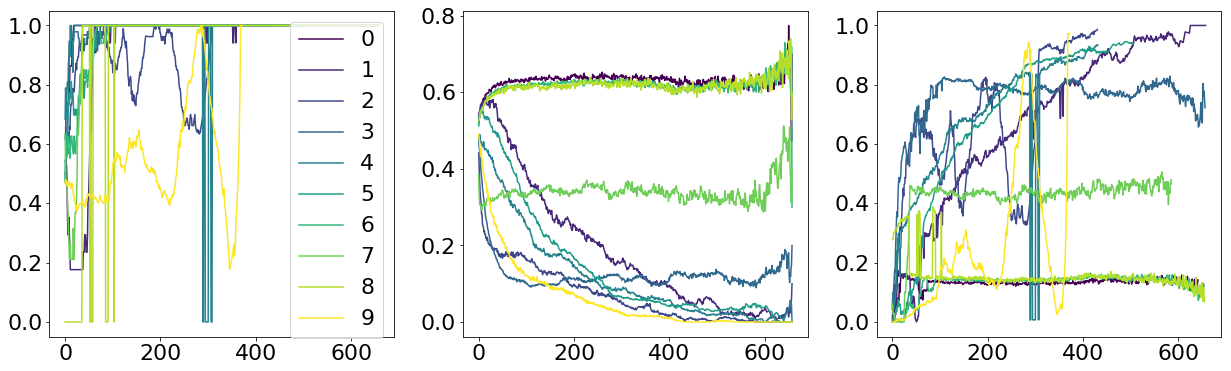

In [329]:
fig,axs=plt.subplots(1,3,figsize=(21,6))
colors = plt.cm.viridis(np.linspace(0,1,modelfit.n_components))
for i in range(modelfit.n_components):
    idxs1 = np.where(np.isfinite(probHigher[i]))[0]
    axs[0].plot(np.arange(testdat.shape[0])[idxs1], probHigher[i, idxs1], color = colors[i], label='{0}'.format(i))
    
    #idxs = np.where(np.isfinite(probLower[i]))[0]
    #axs[1].plot(np.arange(testdat.shape[0])[idxs], probLower[i, idxs], color = colors[i], label='{0}'.format(i))
    
    idxs2 = np.where(np.isfinite(probHigherSim[i]))[0]
    axs[1].plot(np.arange(testdat.shape[0])[idxs2], probHigherSim[i, idxs2], color = colors[i], label='{0}'.format(i))
    
    idxs3 = np.intersect1d(idxs1,idxs2)
    axs[2].plot(np.arange(testdat.shape[0])[idxs3], (probHigher[i, idxs3]-probHigherSim[i, idxs3])**2, color = colors[i], label='{0}'.format(i))
#axs[0].legend(loc=(1,0))
axs[0].legend()
#axs[0].set_yscale('symlog')


In [143]:
#modelfit.sample(100)

In [145]:
#print(hml.hmm.GaussianHMM.__doc__)

In [149]:
statesTr = modelfit.predict(traindat)
statesTe = modelfit.predict(testdat)

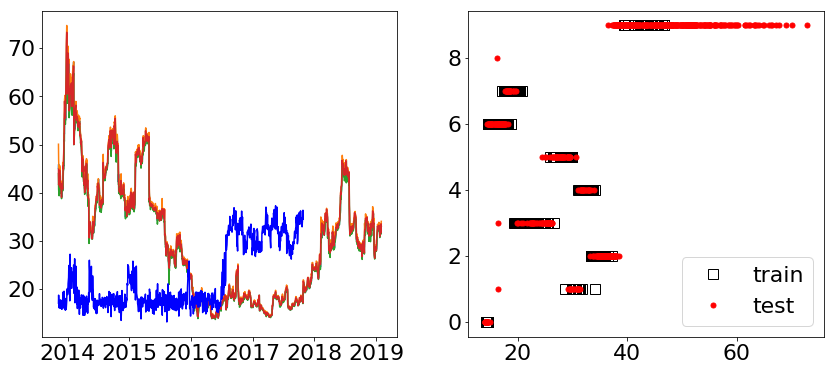

In [152]:
fig,axs=plt.subplots(1,2, figsize=(14,6))
axs[0].plot(timesa, prices[:,0:4])
axs[0].plot(timesa[-1000:],modelfit.sample(1000)[0][:,0], color='b')
#axs[1].plot(timesa, prices[:,4])

axs[1].plot(traindat, statesTr, 'ks', markersize=10, fillstyle='none', label = 'train')
axs[1].plot(testdat, statesTe, 'ro', markersize=5, label='test')
axs[1].legend()


In [ ]:
# to test a model, i could 
# (0) divide a data set into training and testing parts, such that testing parts have length L
# (1) train a model on training data
# (2) generate N samples from the model of length L
# (3) group samples by their starting state --> S(i) = set of all samples that start in state i
# (4) compare samples with test data (e.g., using mean and variance)
#         for same number of components, i'd expect that error bars increase over time
#         at same time points i'd expect that error bars are larger for larger number of components

In [238]:
d2s = [traindat[i:,0] for i in np.where(statesTr==2)[0]]
d4s = [traindat[i:,0] for i in np.where(statesTr==4)[0]]

In [197]:
nsamps = 100
samps = [modelfit.sample(testdat.shape[0],i*1000000+1) for i in range(nsamps)]

In [237]:
len(statesTr)

658

In [211]:
#samps[i][1][0] for i in range(nsamps)]

In [199]:
sampsa= np.array([samp[0] for samp in samps])

In [212]:
sampdats   = [[] for i in range(model.n_components)]
sampstates = [[] for i in range(model.n_components)]
for i in range(len(samps)):
    sampdats[samps[i][1][0]].append(np.array(samps[i][0]))
    sampstates[samps[i][1][0]].append(np.array(samps[i][1]))

In [214]:
sampdats   = [np.array(sd) for sd in sampdats]
sampstates = [np.array(sst) for sst in sampstates]

In [218]:
sampdats[2].shape

(87, 659, 1)

In [229]:
d2s[0]

array([33.56, 33.07, 32.04, ..., 40.5 , 45.93, 45.1 ])

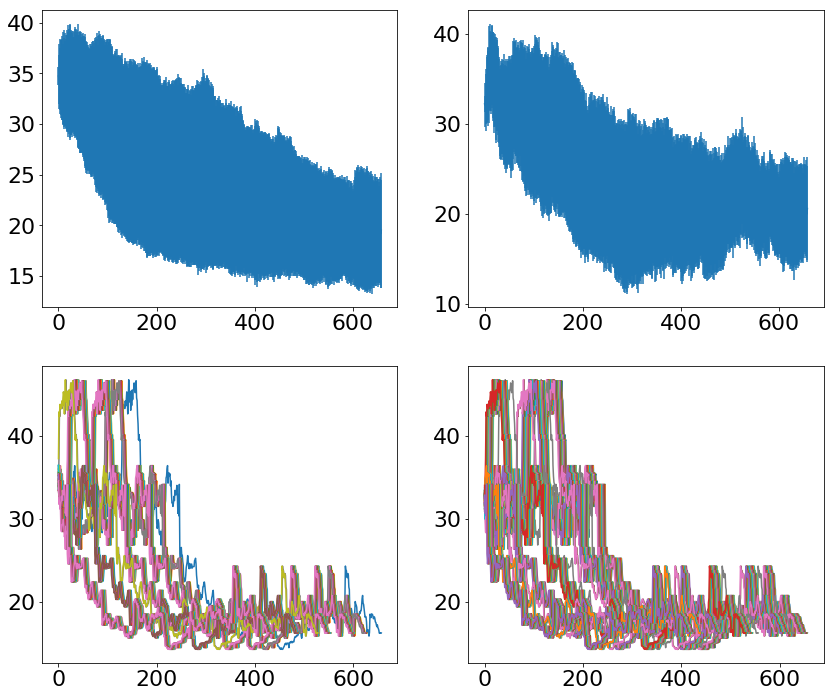

In [239]:
fig,axs=plt.subplots(2,2,figsize=(14,12))
axs[0,0].errorbar(range(testdat.shape[0]),np.mean(sampdats[2][:,:,0],axis=0), yerr=np.std(sampdats[2][:,:,0],axis=0))
axs[0,1].errorbar(range(testdat.shape[0]),np.mean(sampdats[4][:,:,0],axis=0), yerr=np.std(sampdats[2][:,:,0],axis=0))
for i in range(len(d2s)):
    axs[1,0].plot(d2s[i])
for i in range(len(d4s)):
    axs[1,1].plot(d4s[i])

In [216]:
sampdats[4].shape

(13, 659, 1)

In [201]:
print(modelfit.sample.__doc__,54)

Generate random samples from the model.

        Parameters
        ----------
        n_samples : int
            Number of samples to generate.

        random_state : RandomState or an int seed
            A random number generator instance. If ``None``, the object's
            ``random_state`` is used.

        Returns
        -------
        X : array, shape (n_samples, n_features)
            Feature matrix.

        state_sequence : array, shape (n_samples, )
            State sequence produced by the model.
         54


In [202]:
sampStates = np.array([modelfit.predict(samp) for samp in sampsa])

In [194]:
sampStates[:,0]

array([4, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 4, 2, 2, 2, 2, 4, 2, 2, 2,
       2, 4, 2, 2, 4, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2,
       2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2])

In [203]:
sampStates[1],sampStates[2]

(array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 1,
        1, 1, 1, 1, 4, 4, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 4, 4,
        4, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4,
        2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4,
        4, 4, 1, 1, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 7, 7, 7, 7, 7, 7, 7, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7,
        7, 7, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 7, 7, 6, 6, 6, 6, 6,
        7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 6, 6, 6, 0,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 

In [ ]:
sampGroups = {i:[] for i in range(modelfit.n_components)}
for i in range(samps.shape[0]):
    sampGroups[sampStates[i,0]]

In [160]:
np.unique(sampStates)

array([2, 3, 4])

In [135]:
modelfit.sample(100)[0][:,0]

array([31.18047248, 32.30467603, 30.35734633, 30.38345601, 27.70865954,
       32.9656971 , 29.0299404 , 30.41530938, 34.80436139, 30.11014288,
       32.74137191, 25.92516045, 31.0666218 , 34.70165446, 27.812114  ,
       35.33077534, 32.20568074, 29.82021755, 32.57716065, 30.53834798,
       33.97303246, 31.36764196, 32.28552622, 32.64693878, 28.77716854,
       30.73179405, 30.89170556, 31.61447931, 30.83501751, 32.98915468,
       31.86280754, 44.05084682, 43.19485966, 44.16967607, 48.7009376 ,
       42.74415406, 41.08452907, 47.17435701, 41.88142587, 43.01431573,
       43.97516349, 43.17952716, 33.57935664, 30.06164916, 31.14152866,
       34.05693989, 33.56553555, 31.67873222, 31.44835151, 33.49117939,
       29.49317699, 32.40903825, 35.21606284, 31.23423502, 30.09892719,
       32.80390931, 34.68750437, 30.41004255, 30.04228478, 31.66409277,
       31.41626126, 33.12958674, 33.87877658, 35.80347745, 35.04647923,
       27.81632863, 32.61656561, 30.23012617, 33.69136043, 33.57

In [62]:
x[4:8],modelfit.predict(x[[4]])

(array([[3.270500e+01, 3.277000e+01, 3.237000e+01, 3.254000e+01,
         1.386086e+06],
        [3.294000e+01, 3.305000e+01, 3.259000e+01, 3.270000e+01,
         2.332862e+06],
        [3.256500e+01, 3.297900e+01, 3.212000e+01, 3.295000e+01,
         1.005599e+07],
        [3.291900e+01, 3.300000e+01, 3.284500e+01, 3.291000e+01,
         2.403796e+06]]), array([1]))

In [111]:
print(np.around(modelfit.transmat_,3))

[[1.]]


In [48]:
x.shape

(412, 5)

In [32]:
model.score(prices[:,[0]])

-538.4849175503293